In [1]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train/255., X_valid/255. , X_test/255.

The following model applied batch normalization after every hidden layer as the first layer is the input layer.

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                3010      
                                                                 
 batch_normalization_2 (Bat  (None, 10)                4

In [4]:
# parameters of the first batch normalization layer
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

Most of the papers argued to initialize batch normalization layer before the activation function. For that, we need to remove the activation parameter from the hidden layer. Since the batch normalization layer include one offset per parameter per input, you can remove the bias term from the previous layer by passing use_bias=False.

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.summary()

### Gradient Clipping: To Mitigate the Exploding Gradients Problem

In [6]:
model.compile(
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    optimizer = tf.keras.optimizers.SGD(clipvalue=1),  # gradient clipping that may change the direction
    metrics = ["accuracy"]
)
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid,y_valid))

Epoch 1/3
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4762 - accuracy: 0.8687 - val_loss: 0.1752 - val_accuracy: 0.9544
Epoch 2/3
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2294 - accuracy: 0.9355 - val_loss: 0.1243 - val_accuracy: 0.9702
Epoch 3/3
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1735 - accuracy: 0.9514 - val_loss: 0.1032 - val_accuracy: 0.9724


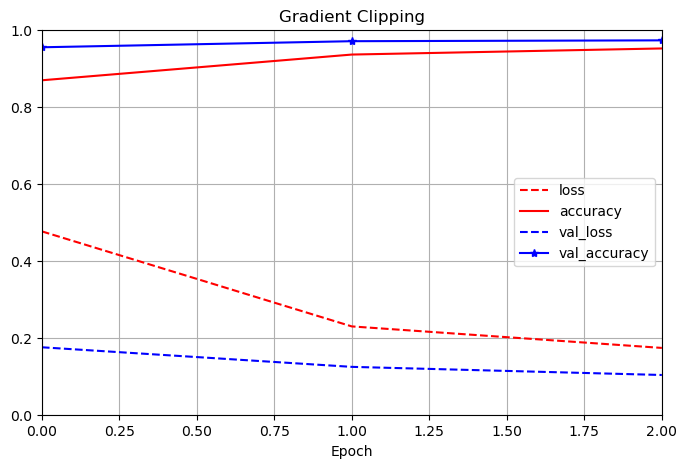

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(
    figsize = (8,5), xlim=[0,2], ylim=[0,1], grid=True, xlabel="Epoch",
    style=["r--", "r-", "b--", "b-*"]
)
plt.title("Gradient Clipping")
plt.show()

In [8]:
model.compile(
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    optimizer = tf.keras.optimizers.SGD(clipnorm=1),  # gradient clipping that maintains the direction
    metrics = ["accuracy"]
)
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid,y_valid))

Epoch 1/3
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1430 - accuracy: 0.9590 - val_loss: 0.0942 - val_accuracy: 0.9748
Epoch 2/3
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1275 - accuracy: 0.9625 - val_loss: 0.0855 - val_accuracy: 0.9778
Epoch 3/3
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1109 - accuracy: 0.9680 - val_loss: 0.0817 - val_accuracy: 0.9782


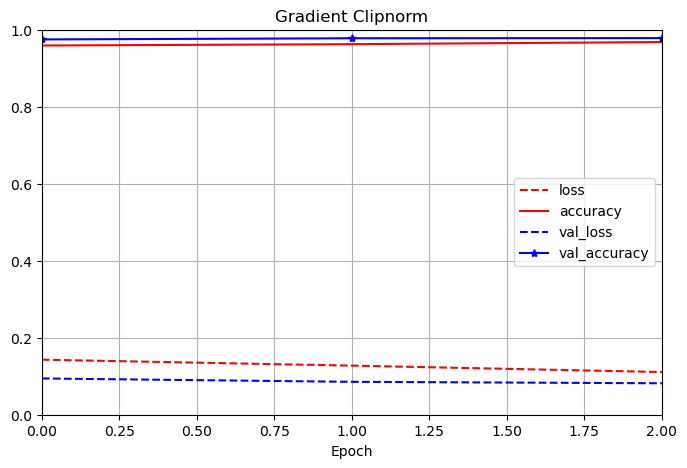

In [9]:
pd.DataFrame(history.history).plot(
    figsize = (8,5), xlim=[0,2], ylim=[0,1], grid=True, xlabel="Epoch",
    style=["r--", "r-", "b--", "b-*"]
)
plt.title("Gradient Clipnorm")
plt.show()

In [10]:
# look gradient clipnorm technique worked better, let's see the result in test data
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0923 - accuracy: 0.9721


[0.0922982394695282, 0.972100019454956]

### Saving and Loading the Model

In [12]:
model.save("my_trained_model", save_format="tf")

INFO:tensorflow:Assets written to: my_trained_model\assets


INFO:tensorflow:Assets written to: my_trained_model\assets


In [16]:
# loading the model
model = tf.keras.models.load_model("my_trained_model")
model.predict(X_test[:1].round())

1/1 [==============================] - 0s 101ms/step


array([[1.0106749e-04, 6.2459105e-05, 1.0523582e-03, 5.9409132e-03,
        1.2397628e-04, 3.4121925e-04, 6.4010837e-06, 9.9224651e-01,
        3.1631338e-05, 9.3479546e-05]], dtype=float32)